In [3]:
import itertools
import pickle
import warnings

import geopandas
import numpy as np
import pandas as pd
import plotly.express as px
from notebook.services.config import ConfigManager
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly

warnings.filterwarnings('ignore')

In [4]:
#Read the data
housing_data = pd.read_csv("Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv")
housing_data.head()

RegionID  SizeRank  RegionName RegionType StateName State      City  \
0     61639         0       10025        Zip        NY    NY  New York   
1     84654         1       60657        Zip        IL    IL   Chicago   
2     61637         2       10023        Zip        NY    NY  New York   
3     91982         3       77494        Zip        TX    TX      Katy   
4     84616         4       60614        Zip        IL    IL   Chicago   

                              Metro       CountyName  2000-01-31  ...  \
0       New York-Newark-Jersey City  New York County         NaN  ...   
1          Chicago-Naperville-Elgin      Cook County    385767.0  ...   
2       New York-Newark-Jersey City  New York County   1436957.0  ...   
3  Houston-The Woodlands-Sugar Land    Harris County    224578.0  ...   
4          Chicago-Naperville-Elgin      Cook County    500382.0  ...   

   2021-05-31  2021-06-30  2021-07-31  2021-08-31  2021-09-30  2021-10-31  \
0   1638961.0   1637564.0   1679727.0   1709169.0   1748295.0   1749339.0   
1    700165.0    703048.0    706888.0    712697.0    716151.0    720679.0   
2   2659070.0   2673698.0   2711883.0   2751219.0   2795416.0   2796826.0   
3    381283.0    390040.0    400791.0    411685.0    420811.0    428772.0   
4    931142.0    934129.0    937812.0    944469.0    948779.0    953615.0   

   2021-11-30  2021-12-31  2022-01-31  2022-02-28  
0   1751304.0   1749010.0   1762297.0   1787599.0  
1    725926.0    730118.0    733433.0    734445.0  
2   2794953.0   2786575.0   2793315.0   2796234.0  
3    435855.0    441594.0    447688.0    457220.0  
4    961174.0    966857.0    972448.0    973540.0  

[5 rows x 275 columns]

In [6]:
#Get the categorical columns so that we can merge with melted numerical columns later.
categorical_columns = housing_data.columns[:9]
categorical_columns = list(categorical_columns)
categorical_columns

['RegionID',
 'SizeRank',
 'RegionName',
 'RegionType',
 'StateName',
 'State',
 'City',
 'Metro',
 'CountyName']

In [7]:
# melt the rows to produce one row per month for every zip code.
housing_data = housing_data.melt(categorical_columns, var_name="Date", value_name="Price")
housing_data[housing_data["RegionName"] == 60657]

RegionID  SizeRank  RegionName RegionType StateName State     City  \
1           84654         1       60657        Zip        IL    IL  Chicago   
30502       84654         1       60657        Zip        IL    IL  Chicago   
61003       84654         1       60657        Zip        IL    IL  Chicago   
91504       84654         1       60657        Zip        IL    IL  Chicago   
122005      84654         1       60657        Zip        IL    IL  Chicago   
...           ...       ...         ...        ...       ...   ...      ...   
7960762     84654         1       60657        Zip        IL    IL  Chicago   
7991263     84654         1       60657        Zip        IL    IL  Chicago   
8021764     84654         1       60657        Zip        IL    IL  Chicago   
8052265     84654         1       60657        Zip        IL    IL  Chicago   
8082766     84654         1       60657        Zip        IL    IL  Chicago   

                            Metro   CountyName        Date     Price  
1        Chicago-Naperville-Elgin  Cook County  2000-01-31  385767.0  
30502    Chicago-Naperville-Elgin  Cook County  2000-02-29  386907.0  
61003    Chicago-Naperville-Elgin  Cook County  2000-03-31  389669.0  
91504    Chicago-Naperville-Elgin  Cook County  2000-04-30  393917.0  
122005   Chicago-Naperville-Elgin  Cook County  2000-05-31  398972.0  
...                           ...          ...         ...       ...  
7960762  Chicago-Naperville-Elgin  Cook County  2021-10-31  720679.0  
7991263  Chicago-Naperville-Elgin  Cook County  2021-11-30  725926.0  
8021764  Chicago-Naperville-Elgin  Cook County  2021-12-31  730118.0  
8052265  Chicago-Naperville-Elgin  Cook County  2022-01-31  733433.0  
8082766  Chicago-Naperville-Elgin  Cook County  2022-02-28  734445.0  

[266 rows x 11 columns]

In [8]:
# convert date column in string format to date time format for Prophet's need.
housing_data['Date'] = pd.to_datetime(housing_data['Date'], infer_datetime_format=True)

In [9]:
# Pick few metros of choice to see the housing trend over the period of years.
major_metros_list = ["Atlanta-Sandy Springs-Roswell", "New York-Newark-Jersey City", "Chicago-Naperville-Elgin",
                     "Los Angeles-Long Beach-Anaheim", "San Francisco-Oakland-Hayward", "Seattle-Tacoma-Bellevue"]
metro_df = housing_data[housing_data['Metro'].isin(major_metros_list)]
# Get the mean house values for the major metros for plotting the trend.
metro_df_mean = metro_df.groupby(["Metro", "Date"], as_index=False).mean()

In [10]:
px.scatter(metro_df_mean, x="Date", y="Price", color='Metro', trendline="lowess",
           labels={"value": "Average House Price", "date": "Year"})

In [12]:
housing_data_original = pd.read_csv("Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv").dropna()
house_temp = housing_data_original.iloc[:, 10:]
house_temp

2000-02-29  2000-03-31  2000-04-30  2000-05-31  2000-06-30  2000-07-31  \
1        386907.0    389669.0    393917.0    398972.0    403092.0    407342.0   
2       1442663.0   1442957.0   1446563.0   1489851.0   1520354.0   1557131.0   
3        224894.0    225618.0    226844.0    226406.0    226070.0    224950.0   
4        501430.0    503944.0    508577.0    514293.0    519413.0    525373.0   
5        106546.0    106349.0    106354.0    106385.0    106597.0    106751.0   
...           ...         ...         ...         ...         ...         ...   
30488    310848.0    312426.0    315903.0    318851.0    322633.0    325145.0   
30489    478410.0    481249.0    483778.0    485991.0    488648.0    494279.0   
30492    326108.0    323275.0    315828.0    301382.0    282389.0    264109.0   
30494    121890.0    119878.0    116641.0    114687.0    114106.0    113201.0   
30495    215022.0    215501.0    216662.0    217997.0    219119.0    219919.0   

       2000-08-31  2000-09-30  2000-10-31  2000-11-30  ...  2021-05-31  \
1        412195.0    416101.0    420732.0    425114.0  ...    700165.0   
2       1557976.0   1581242.0   1603876.0   1611169.0  ...   2659070.0   
3        225291.0    224892.0    225564.0    226722.0  ...    381283.0   
4        532062.0    538292.0    544932.0    551812.0  ...    931142.0   
5        106979.0    107359.0    107593.0    108045.0  ...    216996.0   
...           ...         ...         ...         ...  ...         ...   
30488    335874.0    343204.0    355374.0    357763.0  ...    764058.0   
30489    498716.0    500789.0    500917.0    509565.0  ...   1114056.0   
30492    254145.0    252890.0    254354.0    259828.0  ...    428059.0   
30494    110853.0    109289.0    109659.0    110950.0  ...    200180.0   
30495    220672.0    221659.0    222643.0    223814.0  ...    416055.0   

       2021-06-30  2021-07-31  2021-08-31  2021-09-30  2021-10-31  2021-11-30  \
1        703048.0    706888.0    712697.0    716151.0    720679.0    725926.0   
2       2673698.0   2711883.0   2751219.0   2795416.0   2796826.0   2794953.0   
3        390040.0    400791.0    411685.0    420811.0    428772.0    435855.0   
4        934129.0    937812.0    944469.0    948779.0    953615.0    961174.0   
5        222463.0    228391.0    234711.0    239778.0    244347.0    247689.0   
...           ...         ...         ...         ...         ...         ...   
30488    779471.0    793205.0    801342.0    805509.0    811530.0    820412.0   
30489   1123975.0   1142593.0   1155771.0   1164344.0   1172207.0   1187104.0   
30492    439828.0    461843.0    484477.0    499614.0    511479.0    516714.0   
30494    203391.0    204786.0    210985.0    211154.0    213239.0    212611.0   
30495    426606.0    439333.0    448298.0    455602.0    463755.0    471327.0   

       2021-12-31  2022-01-31  2022-02-28  
1        730118.0    733433.0    734445.0  
2       2786575.0   2793315.0   2796234.0  
3        441594.0    447688.0    457220.0  
4        966857.0    972448.0    973540.0  
5        251604.0    255530.0    260171.0  
...           ...         ...         ...  
30488    838574.0    857067.0    875397.0  
30489   1201826.0   1233334.0   1260433.0  
30492    526437.0    534689.0    539886.0  
30494    212935.0    213932.0    216555.0  
30495    477441.0    488090.0    499357.0  

[13970 rows x 265 columns]

In [13]:
# Find the max and min values of all zips to plot a histogram and box plots to see the distribution of house price.
max = house_temp.max(axis="columns")
min = house_temp.min(axis="columns")
max_min_price_df = pd.DataFrame({"max": max, "min": min, "zip": housing_data_original['RegionName'].astype(int)})
max_min_price_df['variance'] = (max_min_price_df['max'] - max_min_price_df['min']) / max_min_price_df['min']
max_min_price_df['variance'] = max_min_price_df['variance'] * 100

In [14]:
max_min_price_df.describe()

max           min           zip      variance
count  1.397000e+04  1.397000e+04  13970.000000  13970.000000
mean   4.333205e+05  1.588539e+05  44456.132355    163.721132
std    4.486576e+05  1.390036e+05  30457.667653     75.215014
min    1.697900e+04  8.408000e+03   1001.000000     31.488261
25%    1.935558e+05  8.390175e+04  17259.250000    109.874299
50%    3.188350e+05  1.260710e+05  37851.000000    147.203920
75%    5.065388e+05  1.896165e+05  73442.750000    203.422656
max    7.860269e+06  3.292130e+06  99587.000000    799.673696

In [15]:
fig = px.histogram(max_min_price_df, x="variance", marginal="box", labels={"variance": "% of price increase"})
fig.show()

In [ ]:
#!wget https: // github.com / jgoodall / us-maps / raw / master / geojson / zcta5.geo.json

In [16]:
us_zip_geo = geopandas.read_file("zcta5.geo.json")

In [17]:
max_min_price_df.zip = max_min_price_df.zip.astype(int)
us_zip_geo.ZCTA5CE10 = us_zip_geo.ZCTA5CE10.astype(int)
geo_merged_data_frame = us_zip_geo.merge(max_min_price_df, right_on="zip", left_on="ZCTA5CE10")

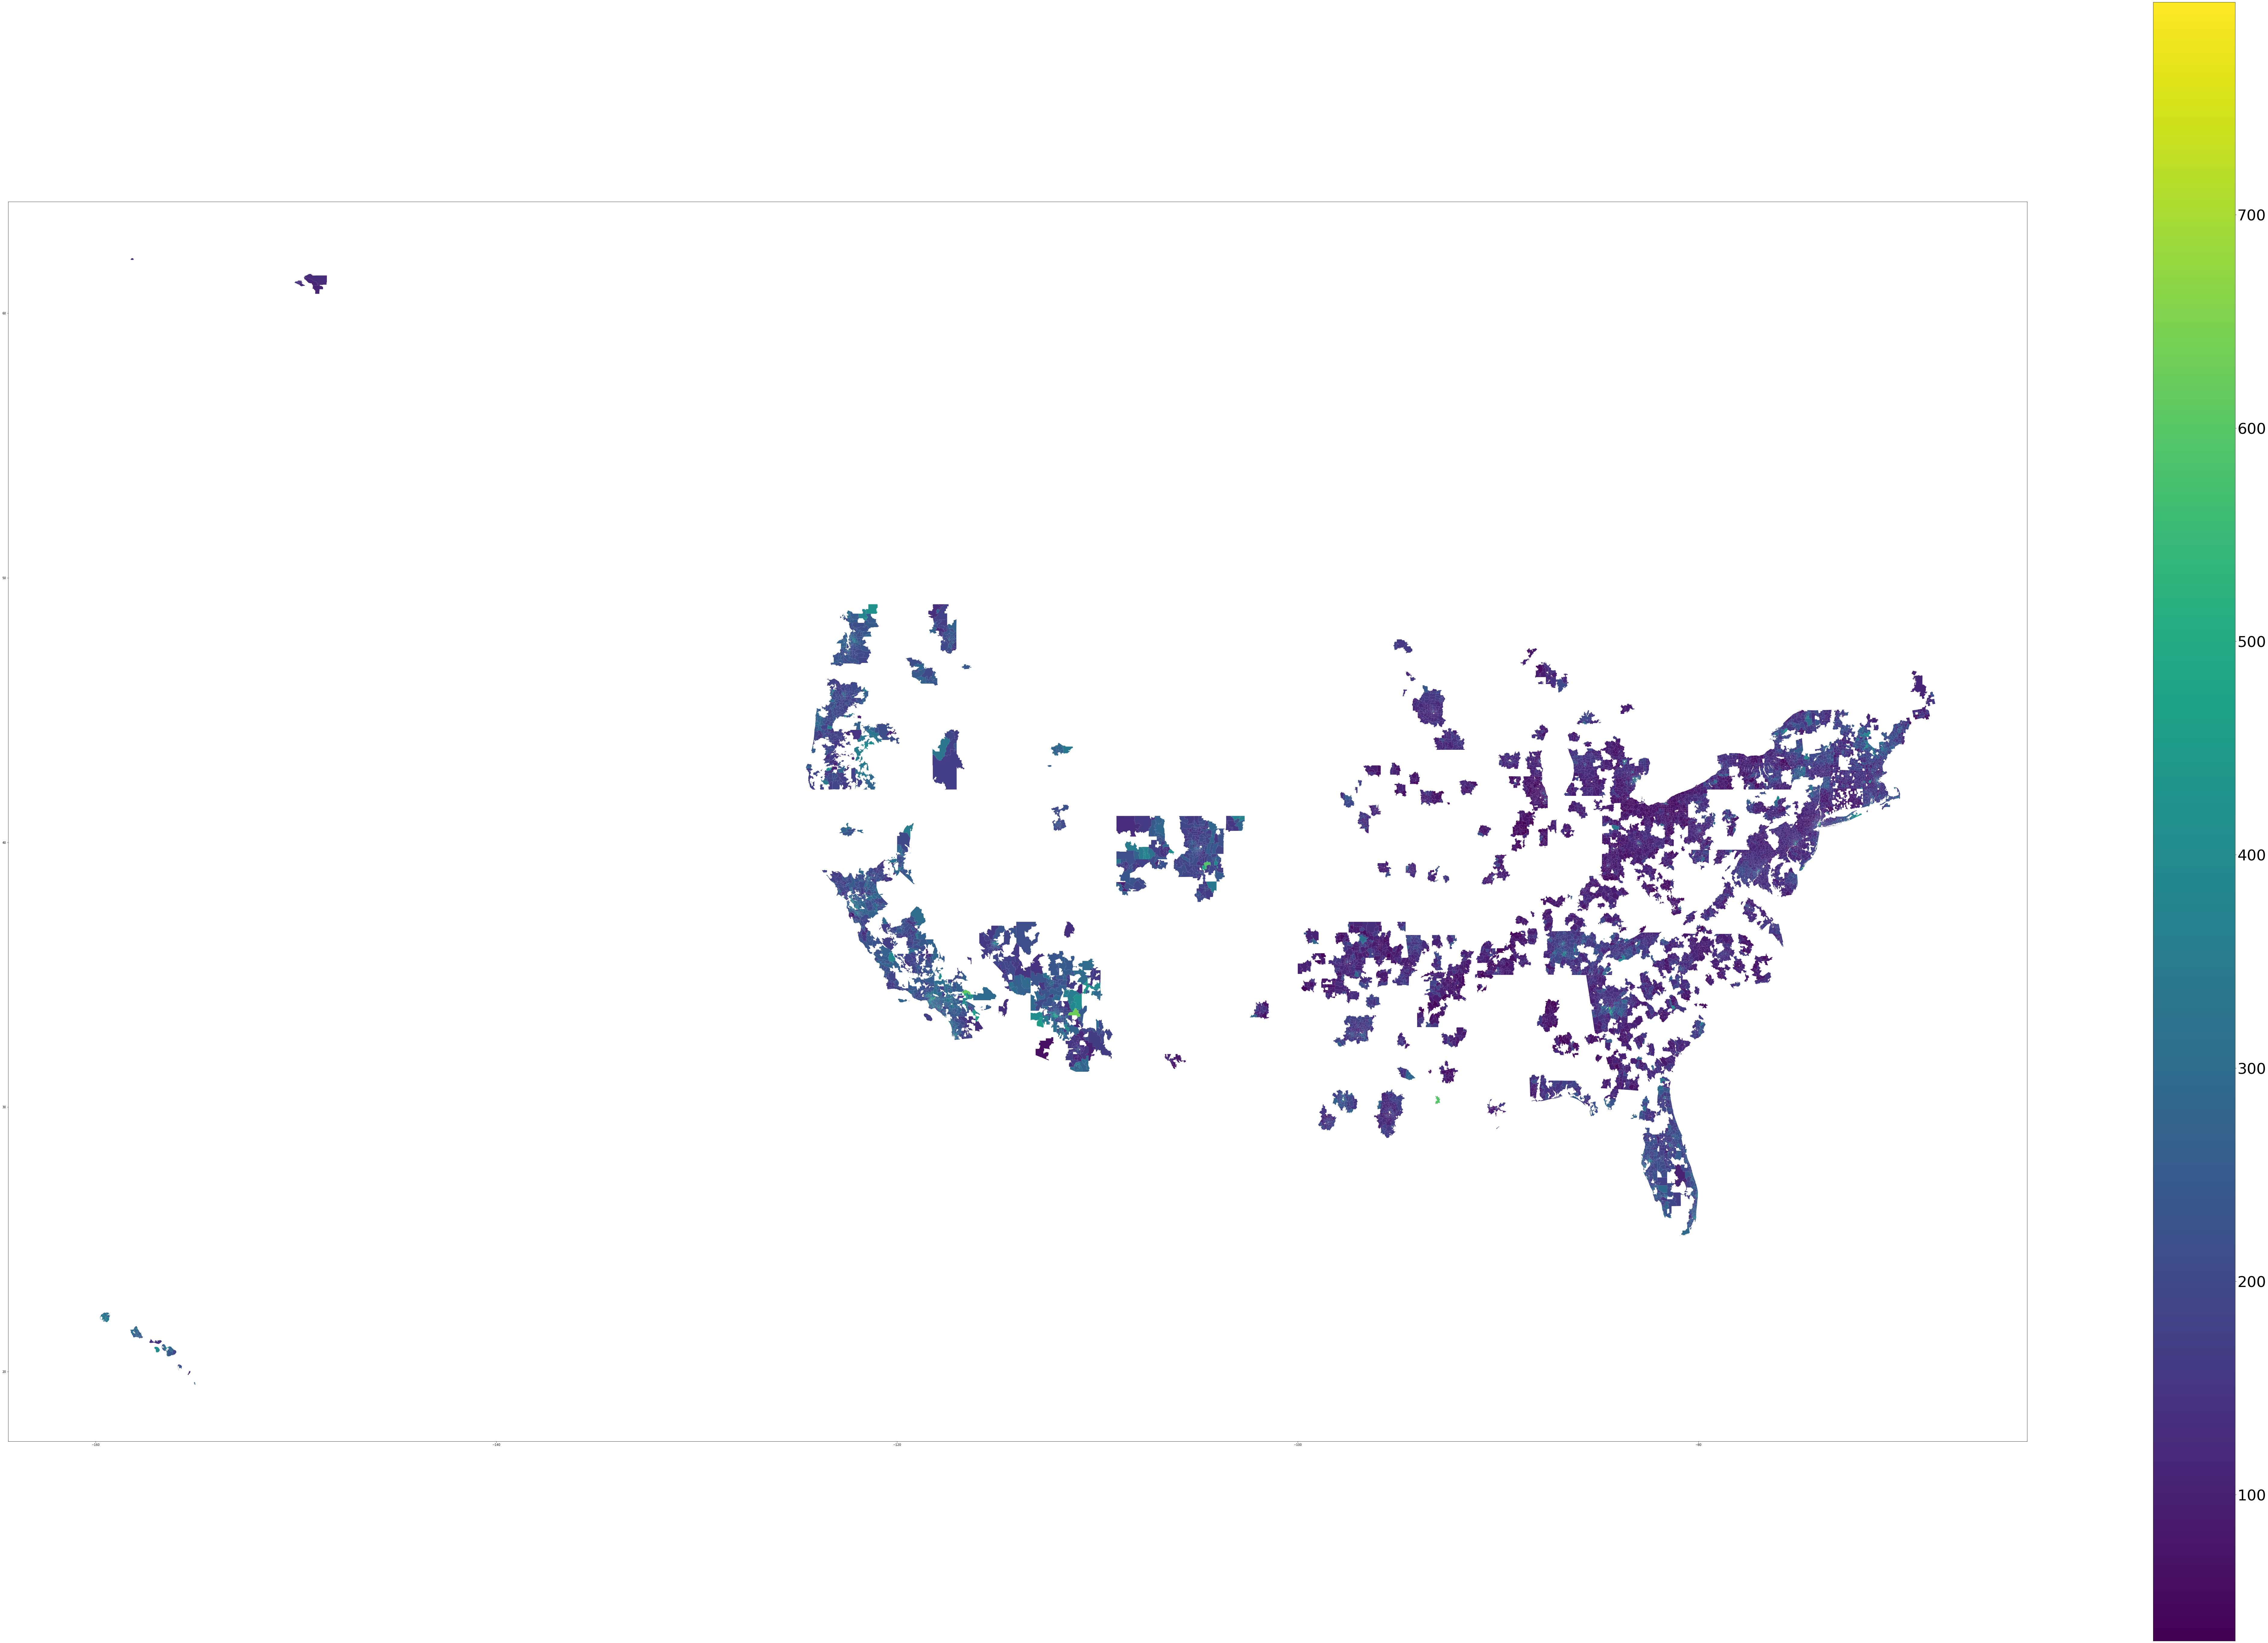

In [18]:
#geo_merged_data_frame = geo_merged_data_frame[geo_merged_data_frame["variance"] > 50]
plot = geo_merged_data_frame.plot(column="variance",
                                  legend=True,
                                  figsize=(150, 100),
                                  legend_kwds={'orientation': "vertical"},
                                  alpha=1)
axes = plot.figure.axes[1]
axes.tick_params(labelsize=50)